In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

try:
    from prophet import Prophet
    from prophet.diagnostics import cross_validation, performance_metrics
    PROPHET_AVAILABLE = True
except ImportError:
    PROPHET_AVAILABLE = False

PROCESSED = "../data/processed/"
FORECAST_MONTHS = 3

In [2]:
df = pd.read_csv(f"{PROCESSED}master_integrated.csv")
df["ds"] = pd.to_datetime(df["year_month"] + "-01")
df = df.sort_values(["region", "ds"]).reset_index(drop=True)

regions = sorted(df["region"].unique())
print(f"✓ Regions     : {regions}")
print(f"  Time range  : {df['ds'].min().date()} → {df['ds'].max().date()}")
print(f"  Rows/region : {len(df) // len(regions)} months")

# Last date in data
last_date    = df["ds"].max()
holdout_start = last_date - pd.DateOffset(months=FORECAST_MONTHS)
print(f"\nHoldout period (evaluation): {holdout_start.date()} → {last_date.date()}")
print(f"  Forecast horizon           : {FORECAST_MONTHS} months beyond {last_date.date()}")

✓ Regions     : ['PL-Central', 'PL-North', 'PL-South']
  Time range  : 2022-01-01 → 2024-12-01
  Rows/region : 36 months

Holdout period (evaluation): 2024-09-01 → 2024-12-01
  Forecast horizon           : 3 months beyond 2024-12-01


In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    """MAPE — ignores zero actuals to avoid division by zero."""
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def moving_average_forecast(series, window=3, steps=3):
    """Simple moving average fallback if Prophet not available."""
    forecasts = []
    hist = list(series)
    for _ in range(steps):
        val = np.mean(hist[-window:])
        forecasts.append(val)
        hist.append(val)
    return forecasts

def build_future_regressors(last_date, n_months):
    """Build regressor values for future forecast periods."""
    future_dates = pd.date_range(
        start=last_date + pd.DateOffset(months=1),
        periods=n_months, freq="MS"
    )
    rainy  = [10, 11, 12, 1, 2, 3]
    dengue = [1, 2, 3]
    school = [6, 7, 12, 1]
    ram    = {2025: [3], 2026: [3]}
    leb    = {2025: [4], 2026: [4]}

    rows = []
    for d in future_dates:
        rows.append({
            "ds"               : d,
            "is_rainy_season"  : int(d.month in rainy),
            "is_dengue_peak"   : int(d.month in dengue),
            "is_school_holiday": int(d.month in school),
            "is_ramadan"       : int(d.month in ram.get(d.year, [])),
            "is_lebaran"       : int(d.month in leb.get(d.year, [])),
        })
    return pd.DataFrame(rows)

In [4]:
all_forecasts  = []
all_evals      = []
model_results  = {}

for region in regions:
    print(f"Region: {region}")
    reg_df = df[df["region"] == region].copy()
    reg_df = reg_df.rename(columns={"total_units_sold": "y"})

    # Split train / holdout
    train = reg_df[reg_df["ds"] <= holdout_start][["ds","y",
        "is_rainy_season","is_dengue_peak","is_school_holiday",
        "is_ramadan","is_lebaran"]].copy()
    test  = reg_df[reg_df["ds"] > holdout_start][["ds","y"]].copy()

    print(f"  Train size: {len(train)} | Test size: {len(test)}")

    if PROPHET_AVAILABLE and len(train) >= 12:
        # Prophet Model
        m = Prophet(
            yearly_seasonality  = True,
            weekly_seasonality  = False,
            daily_seasonality   = False,
            seasonality_mode    = "multiplicative",
            changepoint_prior_scale = 0.05,    # regularize trend changes
            seasonality_prior_scale = 10,
        )
        # Add custom Indonesian seasonal regressors
        for reg_col in ["is_rainy_season","is_dengue_peak",
                         "is_school_holiday","is_ramadan","is_lebaran"]:
            m.add_regressor(reg_col)

        m.fit(train)

        # Evaluate on holdout
        if len(test) > 0:
            future_eval = test[["ds"]].copy()
            future_eval = future_eval.merge(
                reg_df[["ds","is_rainy_season","is_dengue_peak",
                         "is_school_holiday","is_ramadan","is_lebaran"]],
                on="ds", how="left"
            )
            forecast_eval = m.predict(future_eval)
            y_true = test["y"].values
            y_pred = forecast_eval["yhat"].clip(lower=0).values[:len(y_true)]
            mape   = mean_absolute_percentage_error(y_true, y_pred)
            print(f"  MAPE (holdout): {mape:.2f}%")
            all_evals.append({"region": region, "mape": mape, "n_test": len(test)})

        # Forecast 3 months ahead
        future_regressors = build_future_regressors(last_date, FORECAST_MONTHS)
        # Combine history + future for Prophet future df
        future_df = pd.concat([
            train[["ds","is_rainy_season","is_dengue_peak",
                    "is_school_holiday","is_ramadan","is_lebaran"]],
            future_regressors
        ], ignore_index=True)

        forecast = m.predict(future_df)
        forecast_future = forecast[forecast["ds"] > last_date].copy()
        forecast_future["region"]   = region
        forecast_future["model"]    = "Prophet"
        forecast_future["y_actual"] = np.nan

        model_results[region] = {"model": m, "forecast": forecast, "train": train, "test": test}

    else:
        # Moving Average Fallback
        print(f"Using Moving Average fallback (Prophet not available or insufficient data)")
        y_vals   = reg_df["y"].values
        ma_preds = moving_average_forecast(y_vals, window=3, steps=FORECAST_MONTHS)
        future_dates = pd.date_range(
            start=last_date + pd.DateOffset(months=1),
            periods=FORECAST_MONTHS, freq="MS"
        )
        forecast_future = pd.DataFrame({
            "ds"        : future_dates,
            "yhat"      : ma_preds,
            "yhat_lower": [p * 0.85 for p in ma_preds],
            "yhat_upper": [p * 1.15 for p in ma_preds],
            "region"    : region,
            "model"     : "MovingAverage",
            "y_actual"  : np.nan,
        })
        all_evals.append({"region": region, "mape": None, "n_test": 0})

    # Clip negative forecasts
    forecast_future["yhat"]       = forecast_future["yhat"].clip(lower=0)
    forecast_future["yhat_lower"] = forecast_future["yhat_lower"].clip(lower=0)
    forecast_future["yhat_upper"] = forecast_future["yhat_upper"].clip(lower=0)

    all_forecasts.append(forecast_future[["ds","region","model",
                                           "yhat","yhat_lower","yhat_upper","y_actual"]])

Region: PL-Central
  Train size: 33 | Test size: 3


09:03:26 - cmdstanpy - INFO - Chain [1] start processing
09:03:53 - cmdstanpy - INFO - Chain [1] done processing
09:03:54 - cmdstanpy - INFO - Chain [1] start processing


  MAPE (holdout): 8.55%
Region: PL-North
  Train size: 33 | Test size: 3


09:04:21 - cmdstanpy - INFO - Chain [1] done processing
09:04:21 - cmdstanpy - INFO - Chain [1] start processing


  MAPE (holdout): 8.89%
Region: PL-South
  Train size: 33 | Test size: 3


09:04:47 - cmdstanpy - INFO - Chain [1] done processing


  MAPE (holdout): 5.78%


In [5]:
eval_df = pd.DataFrame(all_evals)
print("Model Evaluation Summary")
print(eval_df.to_string(index=False))
if eval_df["mape"].notna().any():
    avg_mape = eval_df["mape"].mean()
    print(f"\nAverage MAPE across regions: {avg_mape:.2f}%")
    print(f"Target: < 15% → {'Achieved' if avg_mape < 15 else 'Review model'}")

Model Evaluation Summary
    region     mape  n_test
PL-Central 8.550235       3
  PL-North 8.887613       3
  PL-South 5.781145       3

Average MAPE across regions: 7.74%
Target: < 15% → Achieved


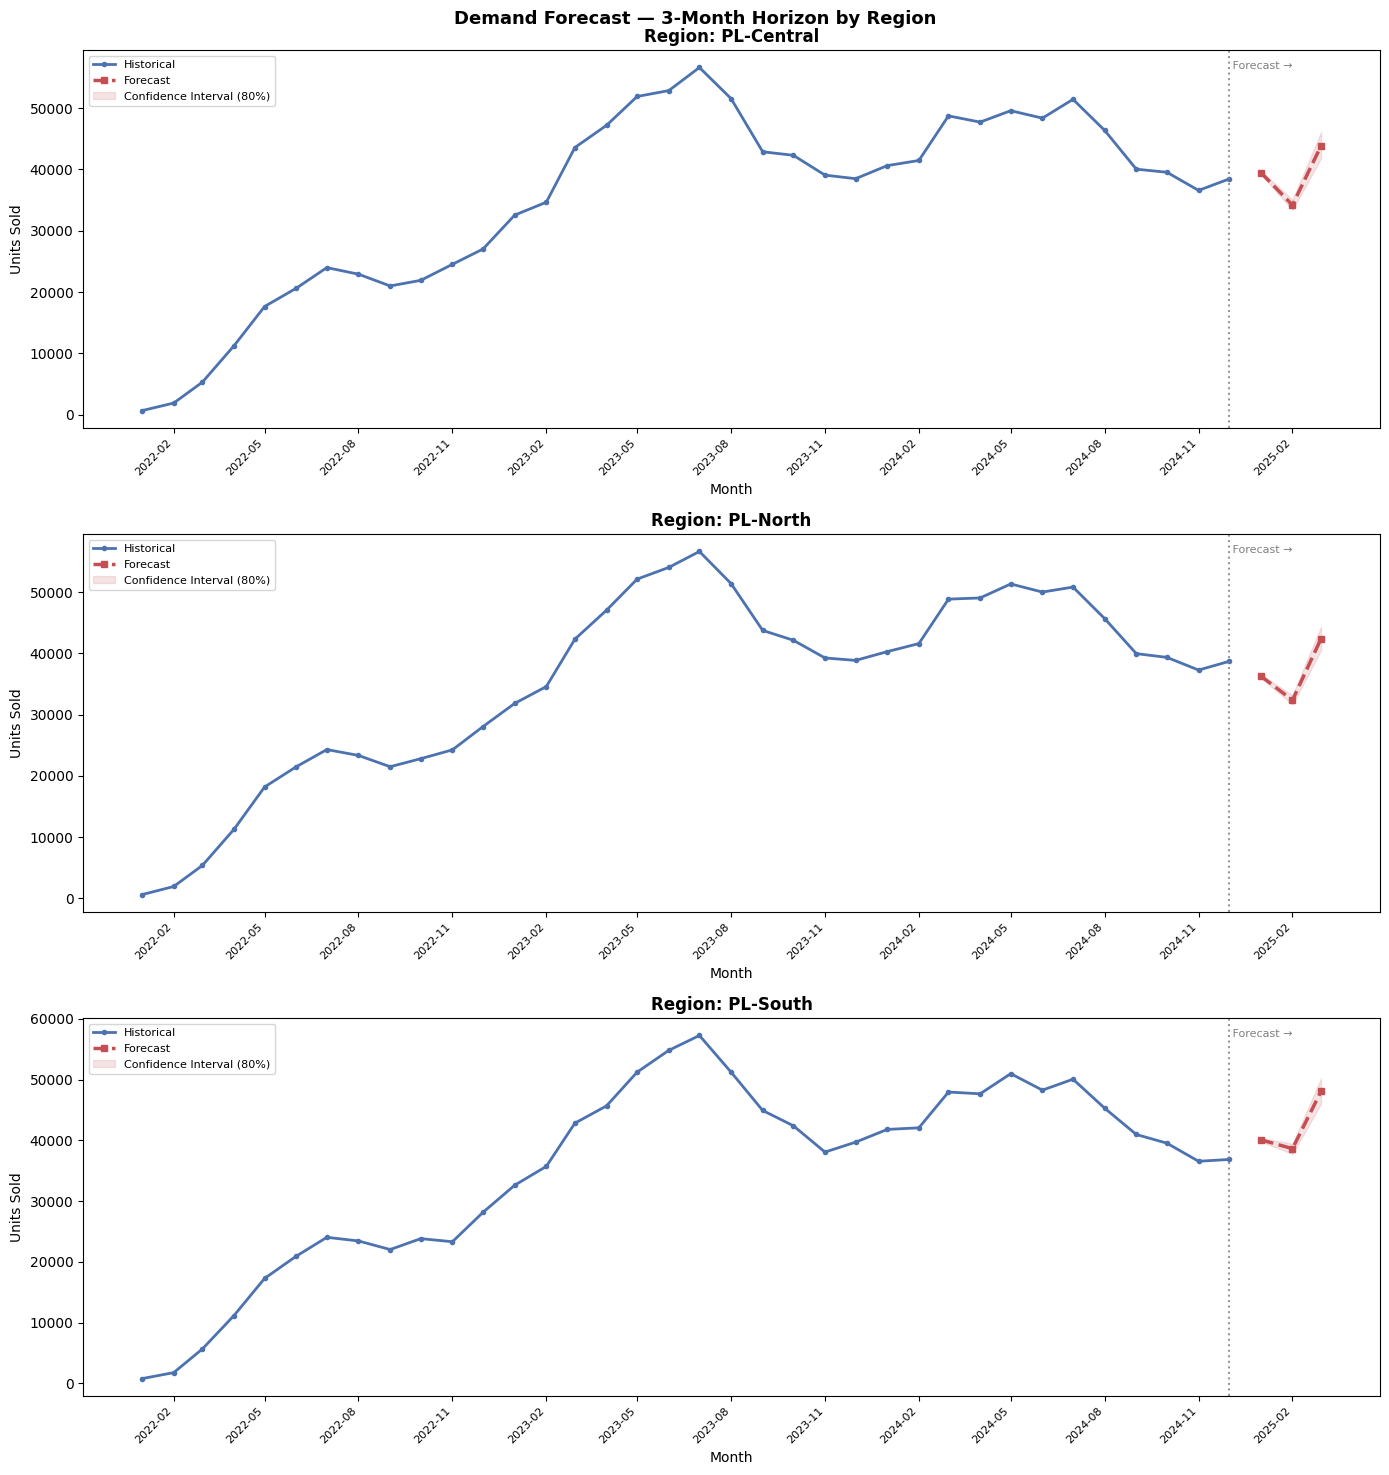

In [6]:
n_regions = len(regions)
fig, axes  = plt.subplots(n_regions, 1, figsize=(14, 5 * n_regions))
if n_regions == 1:
    axes = [axes]

fig.suptitle("Demand Forecast — 3-Month Horizon by Region", fontsize=13, fontweight="bold")

for ax, region in zip(axes, regions):
    reg_hist = df[df["region"] == region].copy()
    fcast    = pd.concat([f for f in all_forecasts if f["region"].iloc[0] == region])

    # Historical
    ax.plot(reg_hist["ds"], reg_hist["total_units_sold"],
            color="#4C72B0", linewidth=2, label="Historical", marker="o", markersize=3)

    # Forecast
    ax.plot(fcast["ds"], fcast["yhat"],
            color="#C44E52", linewidth=2.5, linestyle="--", label="Forecast", marker="s", markersize=5)

    # Confidence interval
    ax.fill_between(fcast["ds"], fcast["yhat_lower"], fcast["yhat_upper"],
                    color="#C44E52", alpha=0.15, label="Confidence Interval (80%)")

    # Vertical line separating history from forecast
    ax.axvline(x=last_date, color="grey", linestyle=":", linewidth=1.5, alpha=0.8)
    ax.text(last_date, ax.get_ylim()[1] * 0.95 if ax.get_ylim()[1] > 0 else 1000,
            " Forecast →", fontsize=8, color="grey")

    # Shade seasonal events in forecast period
    for _, row in fcast.iterrows():
        if PROPHET_AVAILABLE:
            pass  # prophet handles this internally

    ax.set_title(f"Region: {region}", fontweight="bold")
    ax.set_xlabel("Month")
    ax.set_ylabel("Units Sold")
    ax.legend(loc="upper left", fontsize=8)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)

plt.tight_layout()
plt.savefig(f"{PROCESSED}forecast_01_by_region.png", dpi=150, bbox_inches="tight")
plt.show()

Visualize Prophet Trend & Seasonality Components


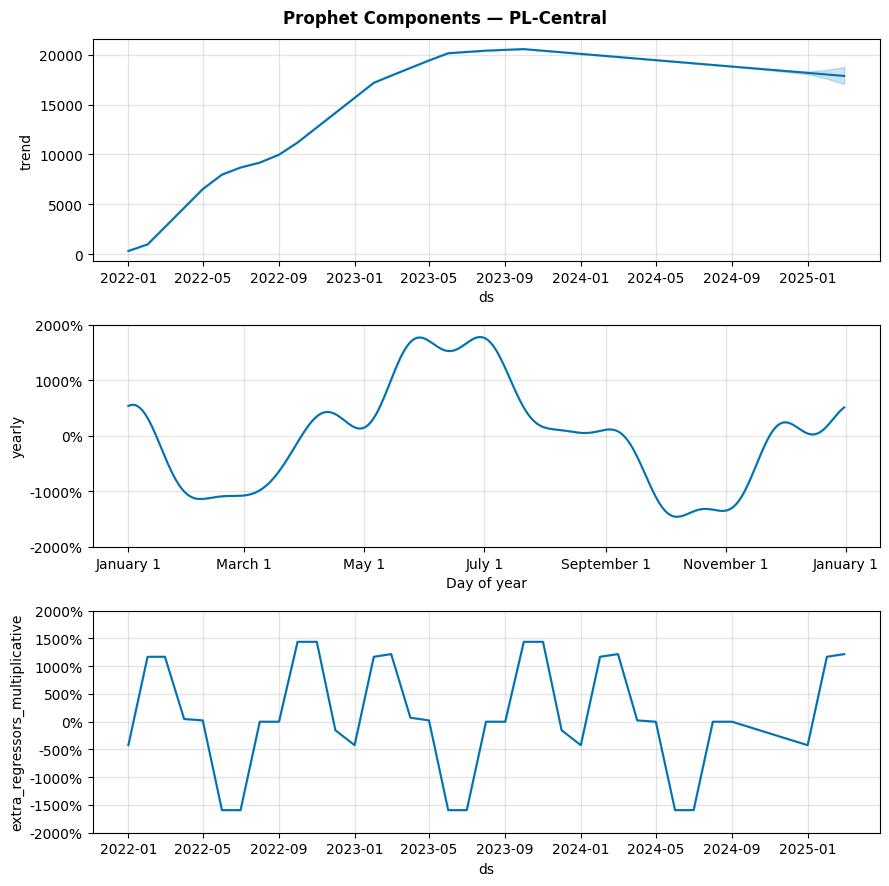

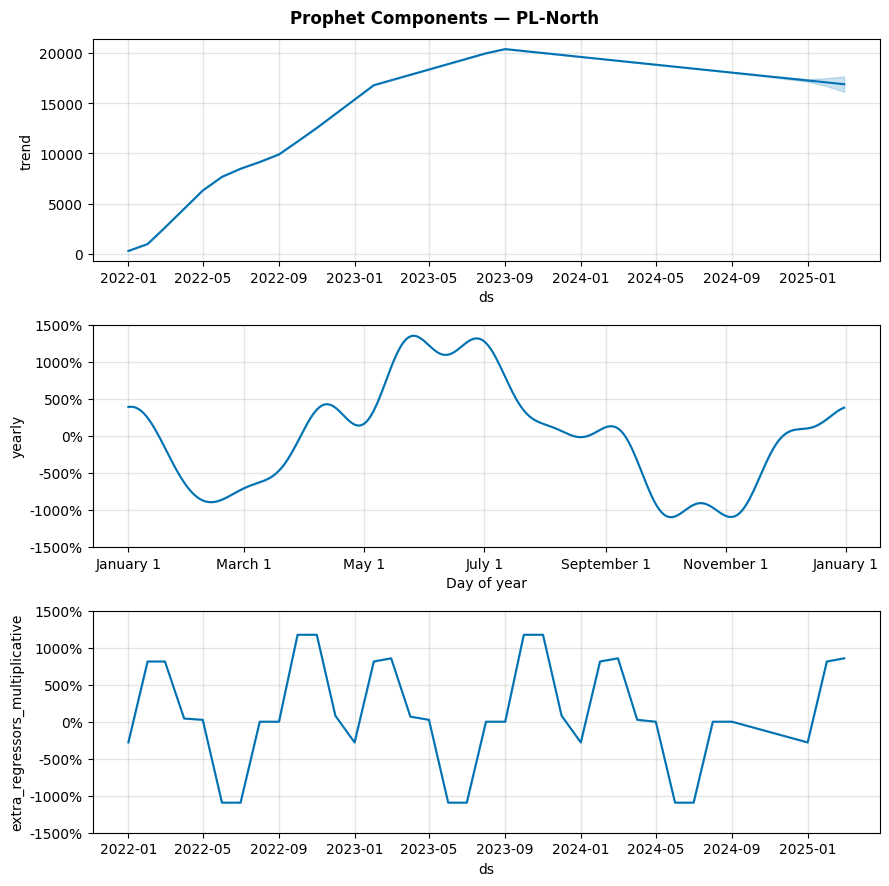

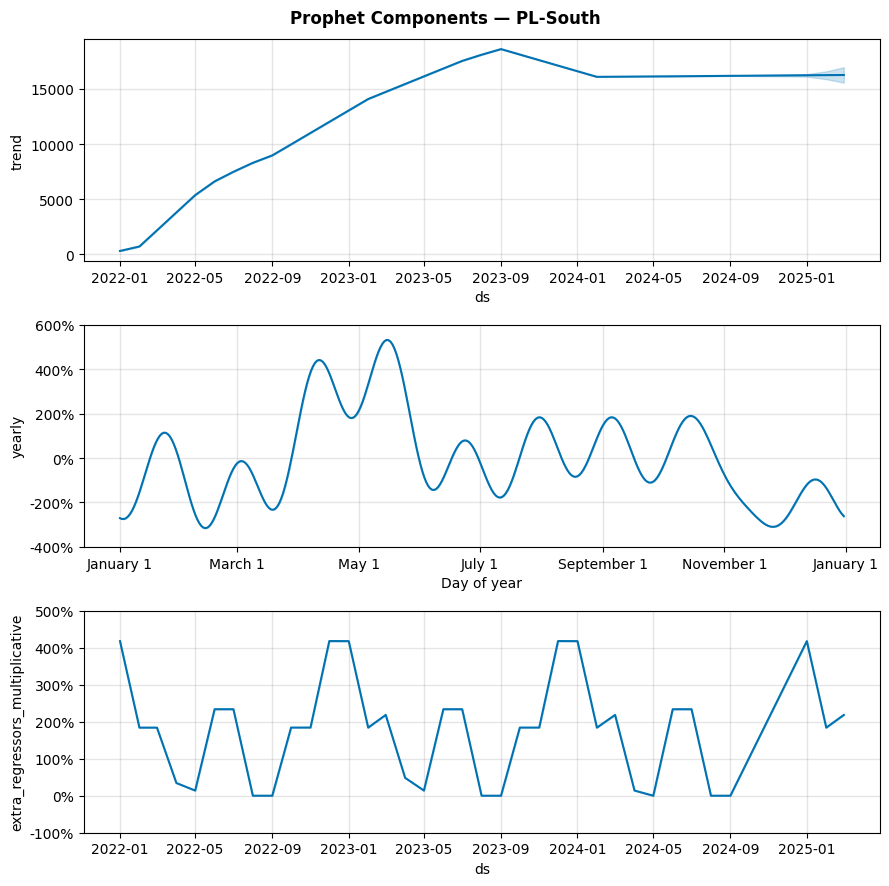

In [7]:
if PROPHET_AVAILABLE and model_results:
    print("Visualize Prophet Trend & Seasonality Components")

    for region, result in model_results.items():
        fig = result["model"].plot_components(result["forecast"])
        fig.suptitle(f"Prophet Components — {region}", fontsize=12, fontweight="bold")
        plt.tight_layout()
        plt.savefig(f"{PROCESSED}forecast_02_components_{region.replace('-','')}.png",
                    dpi=130, bbox_inches="tight")
        plt.show()

In [9]:
# Average revenue per unit from historical data
avg_rev_per_unit = df["total_revenue"].sum() / df["total_units_sold"].sum()
print(f"Avg Revenue per Unit : {avg_rev_per_unit:.4f}")

forecast_all = pd.concat(all_forecasts, ignore_index=True)
forecast_all["projected_revenue"]       = forecast_all["yhat"]       * avg_rev_per_unit
forecast_all["projected_revenue_lower"] = forecast_all["yhat_lower"] * avg_rev_per_unit
forecast_all["projected_revenue_upper"] = forecast_all["yhat_upper"] * avg_rev_per_unit
forecast_all["year_month"]              = forecast_all["ds"].dt.strftime("%Y-%m")

print(f"\nForecast Summary (3-month projection):")
summary = forecast_all.groupby("region").agg(
    forecast_units     = ("yhat",               "sum"),
    forecast_rev       = ("projected_revenue",   "sum"),
    forecast_rev_lower = ("projected_revenue_lower", "sum"),
    forecast_rev_upper = ("projected_revenue_upper", "sum"),
).round(2)
print(summary.to_string())
print(f"\nTotal Projected Revenue (all regions): {summary['forecast_rev'].sum():,.2f}")

Avg Revenue per Unit : 5.2508

Forecast Summary (3-month projection):
            forecast_units  forecast_rev  forecast_rev_lower  forecast_rev_upper
region                                                                          
PL-Central       117516.80     617058.51           600754.47           634962.08
PL-North         111020.97     582950.14           568032.69           598840.41
PL-South         126822.23     665919.57           649114.21           682576.61

Total Projected Revenue (all regions): 1,865,928.22


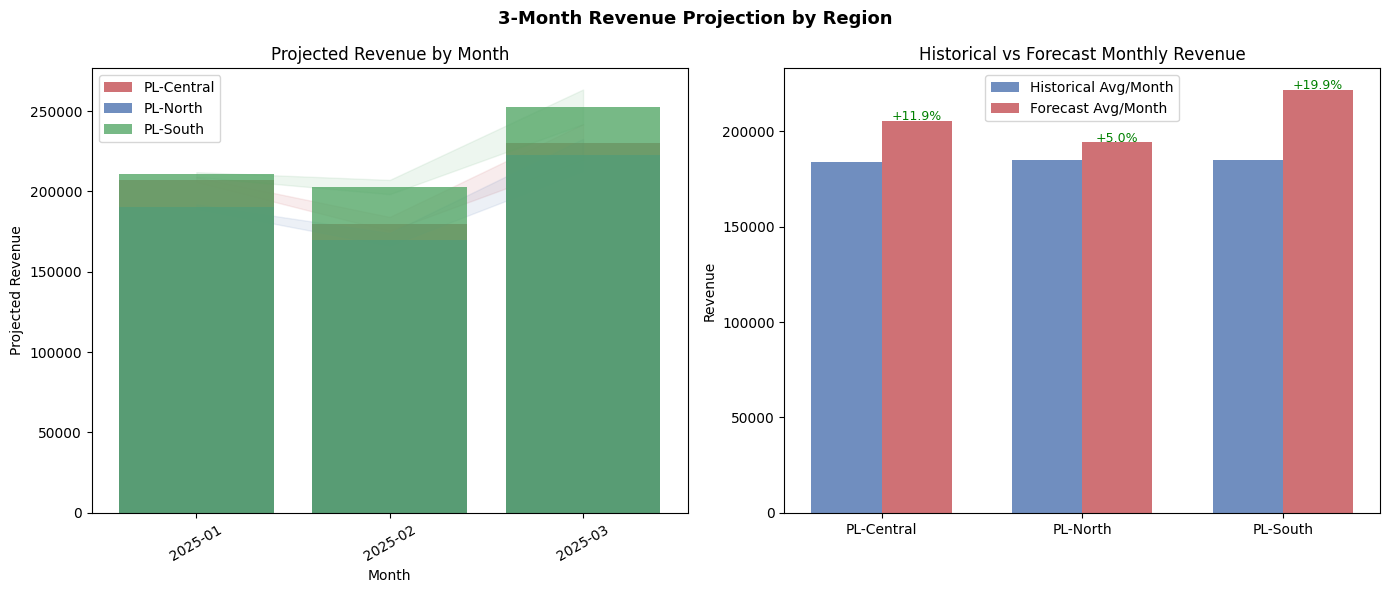

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("3-Month Revenue Projection by Region", fontsize=13, fontweight="bold")

colors = {"PL-Central": "#C44E52", "PL-North": "#4C72B0", "PL-South": "#55A868"}

# Left: Projected revenue per month per region
for region in regions:
    reg_fcast = forecast_all[forecast_all["region"] == region]
    axes[0].bar(reg_fcast["year_month"],
                reg_fcast["projected_revenue"],
                label=region, alpha=0.8,
                color=colors.get(region, "grey"))
    axes[0].fill_between(
        range(len(reg_fcast)),
        reg_fcast["projected_revenue_lower"].values,
        reg_fcast["projected_revenue_upper"].values,
        alpha=0.1, color=colors.get(region, "grey")
    )

axes[0].set_title("Projected Revenue by Month")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Projected Revenue")
axes[0].tick_params(axis="x", rotation=30)
axes[0].legend()

# Right: Total projected vs recent historical avg
hist_avg = df.groupby("region")["total_revenue"].mean()
fcast_avg = summary["forecast_rev"] / FORECAST_MONTHS

comparison = pd.DataFrame({
    "Historical Avg": hist_avg,
    "Forecast Avg"  : fcast_avg,
}).reindex(sorted(regions))

x = np.arange(len(comparison))
width = 0.35
axes[1].bar(x - width/2, comparison["Historical Avg"],
            width, label="Historical Avg/Month", color="#4C72B0", alpha=0.8)
axes[1].bar(x + width/2, comparison["Forecast Avg"],
            width, label="Forecast Avg/Month",   color="#C44E52", alpha=0.8)
axes[1].set_title("Historical vs Forecast Monthly Revenue")
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison.index)
axes[1].set_ylabel("Revenue")
axes[1].legend()

for i, (h, f) in enumerate(zip(comparison["Historical Avg"], comparison["Forecast Avg"])):
    pct_change = ((f - h) / h * 100)
    axes[1].annotate(f"{pct_change:+.1f}%",
                     xy=(i + width/2, f + 50),
                     ha="center", fontsize=9,
                     color="green" if pct_change >= 0 else "red")

plt.tight_layout()
plt.savefig(f"{PROCESSED}forecast_03_revenue_projection.png", dpi=150, bbox_inches="tight")
plt.show()

In [11]:
forecast_export = forecast_all[[
    "year_month","ds","region","model",
    "yhat","yhat_lower","yhat_upper",
    "projected_revenue","projected_revenue_lower","projected_revenue_upper"
]].rename(columns={
    "ds"          : "forecast_date",
    "yhat"        : "forecast_units",
    "yhat_lower"  : "forecast_units_lower",
    "yhat_upper"  : "forecast_units_upper",
})
forecast_export.to_csv(f"{PROCESSED}forecast_results.csv", index=False)

In [12]:
# Summary by region
summary_export = summary.reset_index()
summary_export.to_csv(f"{PROCESSED}forecast_summary.csv", index=False)
print(f"forecast_summary.csv  : {summary_export.shape}")

# Evaluation metrics
eval_df.to_csv(f"{PROCESSED}forecast_evaluation.csv", index=False)
print(f"forecast_evaluation.csv: {eval_df.shape}")

forecast_summary.csv  : (3, 5)
forecast_evaluation.csv: (3, 3)


In [13]:
if eval_df['mape'].notna().any():
    print(f"Avg MAPE        : {eval_df['mape'].mean():.2f}%")
print(f"Forecast horizon: {FORECAST_MONTHS} months")
print(f"Regions covered : {len(regions)}")
print(f"Total Projected : {summary['forecast_rev'].sum():,.2f}")

Avg MAPE        : 7.74%
Forecast horizon: 3 months
Regions covered : 3
Total Projected : 1,865,928.22
